In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('./data/reg.csv', index_col=[0])

In [6]:
X = df.drop("Price",axis=1).to_numpy()
Y = df["Price"].to_numpy().reshape((-1,1))

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

In [45]:
class TensorData(Dataset):
    def __init__(self, x_data, y_data) -> None:
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

trainsets = TensorData(X_train, Y_train)
trainloader = DataLoader(trainsets, batch_size=32, shuffle=True)
testsets = TensorData(X_test, Y_test)
testloader = DataLoader(testsets, batch_size=32, shuffle=True)



In [46]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(13,50,bias=True)
        self.fc2 = nn.Linear(50,30,bias=True)
        self.fc3 = nn.Linear(30,1,bias=True)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))

        return x

    

In [60]:
model = Regressor()
criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7)
import madgrad
optimizer = madgrad.MADGRAD(model.parameters())


In [61]:
iter(trainloader).next()[1].shape

torch.Size([32, 1])

In [62]:
loss_ = []
n = len(trainloader)
for epoch in range(401):
    running_loss = 0.0
    for data in trainloader:
        inputs, values = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, values)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if epoch % 50 == 0:
        print(f'epoch {epoch} : {running_loss/n}')

    loss_.append(running_loss/n)

epoch 0 : 0.0778453960083425
epoch 50 : 0.01584016508422792
epoch 100 : 0.01276300597237423
epoch 150 : 0.009326042782049626
epoch 200 : 0.009918892290443182
epoch 250 : 0.010748666885774583
epoch 300 : 0.009313166257925332
epoch 350 : 0.008764814061578363
epoch 400 : 0.006884123897179961


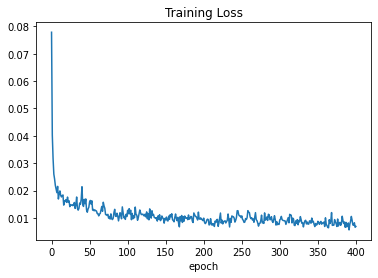

In [63]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

In [64]:
def evaluation(dataloader):

    predictions = torch.tensor([], dtype=torch.float)
    actual = torch.tensor([], dtype=torch.float)
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            inputs, values = data
            outputs = model(inputs)
            predictions = torch.cat((predictions, outputs), 0)
            actual = torch.cat((actual, values), 0)

    predictions = predictions.numpy()
    actual = actual.numpy()
    rmse = np.sqrt(mean_squared_error(predictions, actual))

    return rmse


In [65]:
train_rmse = evaluation(trainloader)
test_rmse = evaluation(testloader)

print("train rmse : ", train_rmse)
print("test rmse : ", test_rmse)

train rmse :  0.060637984
test rmse :  0.11726831
